## Notebook for splitting beads from Slide-seq data

In [1]:
path_to_data = "path/to/data"
path_to_results = "path/to/results"

In [2]:
# can use within the provided TACCO conda environment

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import tacco as tc

In [4]:
### colors for plotting cell types
colors=pd.Series(dtype=object)
colors['MBC']='#73d56d'
colors['MBC_stem-like']='#146c18'
colors['MBC_neuronal']='#39a13c'
colors['MBC_chondroid']='#003b00'

colors['Endothelial']='#feb052'
colors['Endothelial_sinusoidal']='#6d0000'
colors['Endothelial_angiogenic']='#dc7014'
colors['Endothelial_vascular']='#aa3700'

colors['Fibroblast']='#ced208'
colors['Chondrocyte']='#515900'
colors['Smooth muscle_vascular']='#748000'
colors['Stellate']='#323400'
colors['Skeletal muscle']='#a0a800'

colors['Adipocytes']='#bb6fc4'
colors['Hepatocyte']='#f3a3f6'
colors['Keratinocyte']='#53065f'
colors['Neuron']='#873b92'

colors['Macrophage']='#99d1fe'
colors['Monocyte']='#387fb9'
colors['Neutrophil']='#003365'
colors['Erythrocyte']='#66a8dd'
colors['Mast']='#1a588e'

colors['B_plasma']='#f86652'
colors['B']='#cf1917'
colors['T']='#fbb2a1'
colors['NK']='#860000'

### Load Slide-seq and scRNA-seq reference data

In [5]:
sample='HTAPP-895-SMP-7359'

In [6]:
puck_typing = 'RCTD'
sc_typing = 'cell_type'

In [7]:
# Slide-seq anndata object
puck_file = path_to_data+sample+"_slide_seq_processed.h5ad"
tdata=sc.read_h5ad(puck_file)

In [8]:
# scRNA-seq anndata object
sc_file = path_to_data+sample+"_scRNAseq_processed.h5ad"
adata=sc.read_h5ad(sc_file)

### Running Tacco for Bead Splitting

In [9]:
tdata = tc.get.counts(adata=tdata, counts_location=('obsm','counts'), annotation=[puck_typing,'x','y','replicate'])
adata = tc.get.counts(adata=adata, counts_location=('obsm','counts'), annotation=sc_typing)

In [10]:
(tdata,adata) = tc.pp.filter((tdata,adata), return_view=False)

In [11]:
# Use single cell reference to construct reference profiles
adata = tc.pp.construct_reference_profiles(adata=adata, annotation_key=sc_typing)
tdata.varm[puck_typing] = adata.varm[sc_typing]

In [12]:
# Split Slide-seq beads
sdata = tc.tl.split_observations(adata=tdata, annotation_key=puck_typing, min_counts=10)

scale.....time 21.579293251037598
fuseall...time 18.44268560409546


In [13]:
# Associate cell types with colors
sel_colors=colors[colors.index.isin(tdata.obsm[puck_typing].columns)]
sdata.obs[puck_typing]=pd.Categorical(sdata.obs[puck_typing], categories=sel_colors.index,ordered=True)
sdata.uns[puck_typing+"_colors"]=list(sel_colors.values)

/data/core-genlmu/common/mambaforge/envs/TACCO_slidecna/lib/python3.11/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum(axis=-1)[...,None]
/data/core-genlmu/common/mambaforge/envs/TACCO_slidecna/lib/python3.11/site-packages/matplotlib/colors.py:2222: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


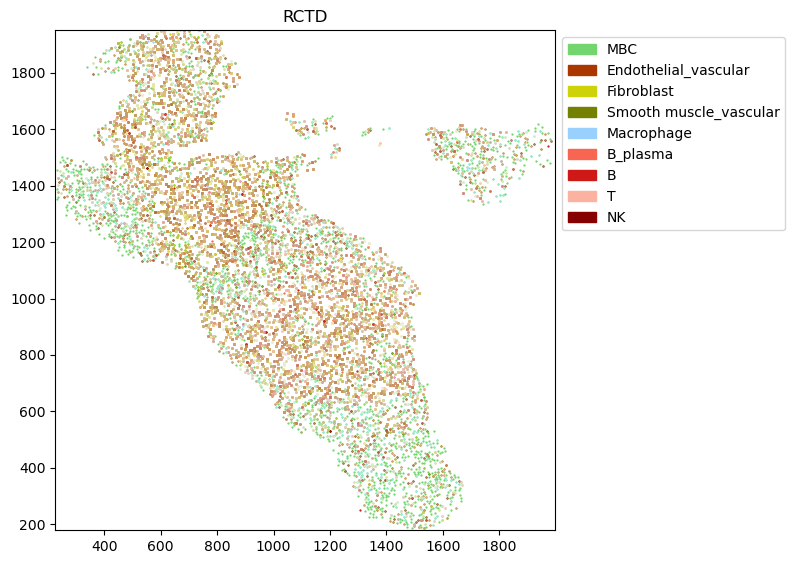

In [14]:
# Plot RCTD cell types across space of split beads
tc.pl.scatter(sdata,
              keys=["RCTD"],
              joint=True,
              point_size=2,
              colors=sel_colors);

In [15]:
# to update
out_file =  path_to_results+sample+"_slide-seq_processed_bs.h5ad"

In [16]:
sdata.write(out_file)

In [17]:
# Get UMAP

In [18]:
pdata=tc.utils.umap_single_cell_data(sdata, hvg=False, min_cells=3)

SCumap...

/data/core-genlmu/common/mambaforge/envs/TACCO_slidecna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time 133.55168843269348


In [19]:
sc.tl.leiden(pdata, random_state=42, resolution=1)

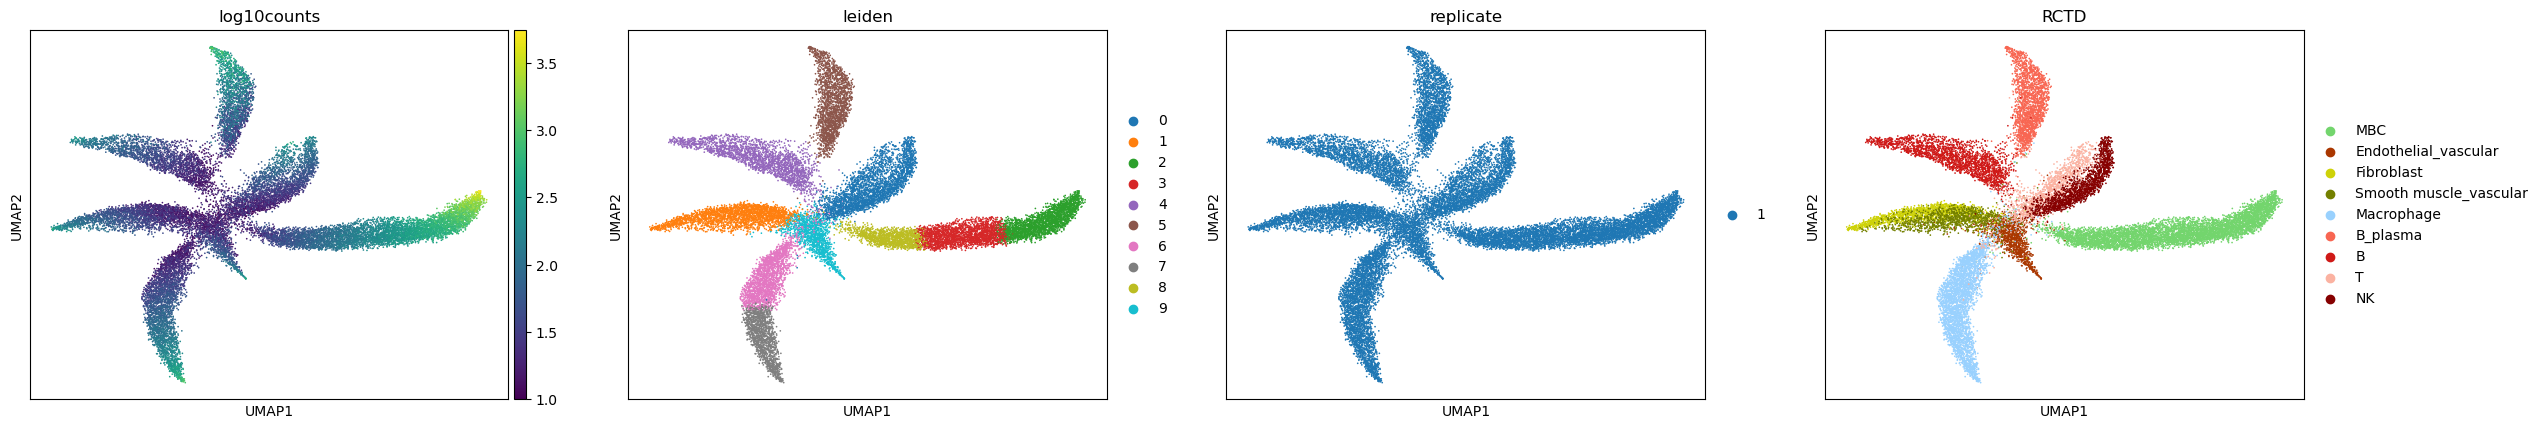

In [20]:
sc.pl.umap(pdata, color=('log10counts','leiden','replicate','RCTD'))